In [1]:
import os, sys
import h5py

import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
from scipy.stats import iqr

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
%matplotlib inline

from matplotlib.colors import LogNorm, SymLogNorm
plt.rcParams['image.cmap'] = 'terrain_r'

import geom

sys.path.append('..')
from sprmodel import SprModelRadial, SprModel

In [2]:
basedir = "../data"
geom_fname = os.path.join(basedir, "agipd_taw9_oy2_1050addu_hmg5.geom")
geom_xy = geom.pixel_maps_from_geometry_file(geom_fname)

modules = (3, 4, 14, 15)

eV = 1.6021766208e-19
hc = 6.6260700400E-34 * 299792458

L = 5.465
lx = 200e-6
ly = 200e-6
Eph = 9200


lmd = hc / Eph / eV
lmd *= 1e10
lmd2 = lmd*lmd


In [3]:
bkgrd_set = {
    (71, 115): 59,
    (127, 198): [119, -2., 1.],
    (214, 280): [119, 4., 2.],
    (293, 296): [291, 4., 2.],
    (297, 320): [291, 4., 2.],
    (481, 513): [474, 4., 2.],
}

def get_calib_fn(run):
    for bruns, meta in bkgrd_set.items():
        if bruns[0] <= run and run < bruns[1]:
            return meta[0], bruns[0], bruns[1], meta[1], meta[2]
    
    print('Background not found')
    return 0, 0, 0

In [4]:
run = 312
hit = 0 #9315

In [5]:
crun, r0, rN, sx, sy = get_calib_fn(run)
print('Calib run: {}, background runs: {}-{}'.format(crun, r0, rN))
print('Inital center: {}, {}'.format(sx, sy))

Calib run: 291, background runs: 297-320
Inital center: 4.0, 2.0


In [6]:
f=h5py.File(os.path.join(basedir, 'hits/example-r{:04d}.h5'.format(run)), 'r')
x0, y0, width = f['geom/x0'][:], f['geom/y0'][:], f['geom/width'][:]

print(x0, y0, width)

im = f['hits/image'][hit,:]
sig = f['hits/noise'][hit,:]
badpx = f['hits/badpx'][hit,:]
im[badpx] = 0

en = f['hits/en'][hit]
print(en, im.sum())
f.close()


[ 33.] [ 36.] [ 212.]
1359.01 10257.4


In [7]:
geom_x = geom_xy[0].reshape(16, 512, 128) - x0
geom_y = geom_xy[1].reshape(16, 512, 128) - y0

offset = np.zeros(17, dtype=int)
map = np.logical_and(
    np.logical_and(-width < geom_x, geom_x < width),
    np.logical_and(-width < geom_y, geom_y < width)
)
k0 = 0
for m in range(16):
    offset[m] = k0
    if m in modules:
        k0 += map[m,:,:].sum()
offset[-1] = k0
numpt = k0

x = np.zeros(numpt, dtype=float)
y = np.zeros(numpt, dtype=float)
d = np.zeros(numpt, dtype=float)
s = np.zeros(numpt, dtype=float)
c = np.zeros(numpt, dtype=int)
b = np.zeros(numpt, dtype=int)
for m in modules:
    k0, kn = offset[m], offset[m+1]
    mp = map[m,:,:]
    x[k0:kn] = geom_x[m,:,:][mp]
    y[k0:kn] = geom_y[m,:,:][mp]

    fn = os.path.join(basedir, "bg/bkgrnd-r{:04d}-r{:04d}-m{:02d}.h5".format(r0,rN,m))
    f = h5py.File(fn, 'r')
    enbg = f["en_avg"][:] / f["cnt_avg"][:]
    d[k0:kn] = f["bkgrnd"][mp]
    c[k0:kn] = f["cnt"][mp]
    
    s[k0:kn] = f["noise"][mp]
    
    b[k0:kn] = c[k0:kn] == 0
    f.close()

print(enbg, b.sum())

[ 1539.3256569] 5742


In [8]:
msk = np.logical_not(np.logical_or(badpx, b))
x = x[msk]
y = y[msk]
im = im[msk]
sig = sig[msk]
bkgrd = d[msk] # * en / enbg
bgsig = s[msk]


In [9]:
nw = 2*int(width)+1
img = np.zeros([nw, nw], dtype=float)
img[:] = 'nan' 
img[(y+width+0.5).astype(int),(x+width+0.5).astype(int)] = im

cm = plt.cm.get_cmap('terrain_r')
cm.set_bad((.98,.98,.98))

mx = im.max()
if mx < 1:
    mx = 1
ss = ((np.log(mx) - np.log(.5)) / (0.5))/100

if False:

    fig = plt.figure(figsize=[10,10])
    ax=fig.gca()


    i=ax.matshow(img, norm=SymLogNorm(0.5, ss, -0.5, mx), cmap=cm)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    plt.colorbar(i, cax=cax)
    ax.set_axis_off()

    plt.show()


In [10]:
ri = np.vstack([x-sx,y-sy]).T
rmod = SprModelRadial(ri, im, bkgrd, sig, bgsig, lmd, [lx/L, ly/L])

flg, r = rmod.solve(700, 1.8, 0.8)
if flg == 0:
    chi2, b0, a0, I0, R = r
    spr = SprModel(ri, im, bkgrd, sig, bgsig, lmd, [lx/L, ly/L], [0., 1.])
    xinit = [b0, 1, I0, R, 0, 0]
    r = spr.solve(xinit, 1e-5)
    print(r)
else:
    spr = None

     corr: array([[  4.45446070e-07,  -6.31558872e-07,  -5.27874609e-06,
          1.16534164e-05,   2.23835811e-07,   3.84568151e-08],
       [ -6.31558872e-07,   1.63624236e-05,  -1.65512481e-06,
         -5.58957402e-06,  -2.40725928e-08,  -1.04570112e-07],
       [ -5.27874609e-06,  -1.65512481e-06,   6.64510335e-03,
         -1.42912600e-02,  -2.62891227e-04,  -7.64601162e-05],
       [  1.16534164e-05,  -5.58957402e-06,  -1.42912600e-02,
          1.12587732e+00,   9.02334981e-03,   3.69608783e-03],
       [  2.23835811e-07,  -2.40725928e-08,  -2.62891227e-04,
          9.02334981e-03,   1.62350031e-04,   6.72494910e-05],
       [  3.84568151e-08,  -1.04570112e-07,  -7.64601162e-05,
          3.69608783e-03,   6.72494910e-05,   1.81684069e-04]])
      fun: array([-0.22487907])
      gof: 1.0717077752595114
     hess: array([[  3.18007806e+01,   1.23006746e+00,   2.54364380e-02,
          3.58744885e-05,  -7.20933019e-03,   6.62013511e-03],
       [  1.23006746e+00,   8.57599951e-

In [11]:
print("1st opt. cond. : {:.1e}".format(np.linalg.norm(r.jac)))
print("2nd opt. cond. : {}".format(r.positive))
print("Goodness of fit: {:.3g}".format(r.gof))
print("")
print("         I [ph/A2]     R [A]    x [px]    y [px]")
print("initial {:10.4g}{:10.5g}{:10.3g}{:10.3g}".format(*xinit[2:]))
print("final   {:10.4g}{:10.5g}{:10.3g}{:10.3g}".format(*r.x[2:]))
print("error   {:10.1e}{:10.1e}{:10.1e}{:10.1e}".format(*np.diag(r.corr)[2:]))

1st opt. cond. : 3.3e-06
2nd opt. cond. : True
Goodness of fit: 1.07

         I [ph/A2]     R [A]    x [px]    y [px]
initial      7.779    4436.8         0         0
final        9.769    4367.6     -0.77    -0.532
error      6.6e-03   1.1e+00   1.6e-04   1.8e-04


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:1122: RuntimeWarning: invalid value encountered in greater
  masked = np.abs(a) > self.linthresh
/opt/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:1122: RuntimeWarning: invalid value encountered in greater
  masked = np.abs(a) > self.linthresh


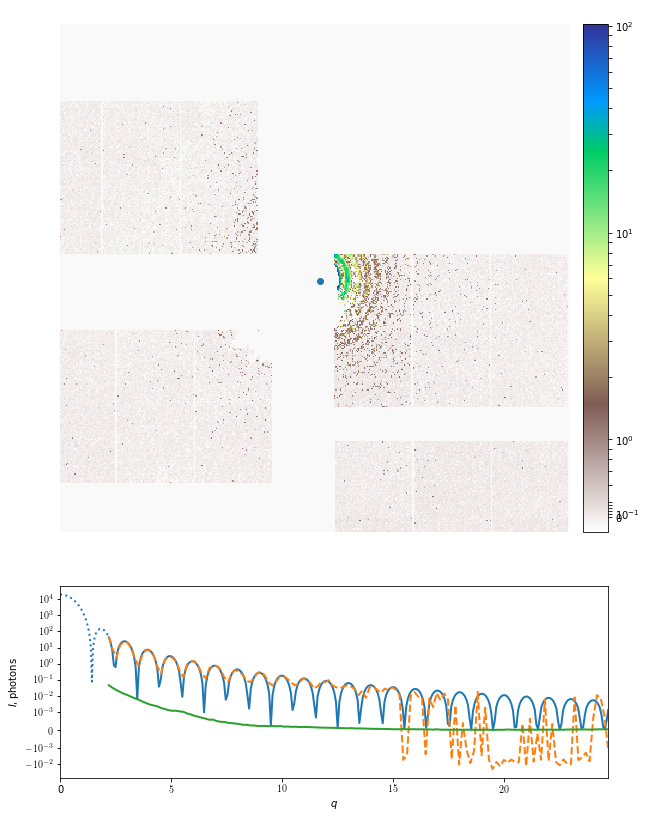

In [12]:
if flg==0:
    b0, ec, I0, R, xc, yc = r.x

    ri2 = np.vstack([x-sx-xc,y-sy-yc]).T
    spr2 = SprModelRadial(ri2, im, bkgrd, sig, bgsig, lmd, [lx/L, ly/L])
    fig = plt.figure(figsize=[9,12])
    
    gs = gridspec.GridSpec(2, 1,
                       height_ratios=[3, 1]
                       )
    ax1 = plt.subplot(gs[0])
    i=ax1.matshow(img, norm=SymLogNorm(0.5, ss, -0.5, mx), cmap=cm)

    plt.plot(sx-xc+width,sy-yc+width, 'o')

    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    plt.colorbar(i, cax=cax)
    ax1.set_axis_off()
    
    ax2 = plt.subplot(gs[1])
    ax2=fig.gca()
    spr2.plot_model(ax2, I0, R, b0, ec, bg=True)
    ax2.set_yscale('symlog', linthreshy=0.001)
    #ax2.set_ylim([0.8,10])
    
    plt.tight_layout()
    fig.savefig("fig_model_1.png", dpi=300)
    plt.show()    